In [1]:
import torch
from torchvision import models, transforms
import torch.nn as nn
import matplotlib.pylab as plt
%matplotlib inline
from _code.color_lib import RGBmean, RGBstdv
from _code.Reader import ImageReader
import numpy as np
from torch.utils.data.sampler import SequentialSampler

def eva(dsets, model):
    Fvecs = []
    dataLoader = torch.utils.data.DataLoader(dsets, batch_size=400, sampler=SequentialSampler(dsets), num_workers=48)
    torch.set_grad_enabled(False)
    model.eval()
    for data in dataLoader:
        inputs_bt, labels_bt = data # <FloatTensor> <LongTensor>
        fvec = model(inputs_bt.cuda())
        fvec = fvec.cpu()
        Fvecs.append(fvec)
            
    return torch.cat(Fvecs,0)

In [2]:
val_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(256),
                                      transforms.ToTensor(),
                                      transforms.Normalize(RGBmean['CUB'], RGBstdv['CUB'])])

data_dict = torch.load('/pless_nfs/home/datasets/CUB/data_dict_emb.pth')

def feature(src):
    model_para = torch.load(src+'model_params.pth')
    model = models.resnet18(pretrained=True)

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 64)
    model.avgpool = nn.AvgPool2d(8)

    model.load_state_dict(model_para,strict=True)
    
    traset = ImageReader(data_dict['tra'], None, val_transforms) 
    valset = ImageReader(data_dict['val'], None, val_transforms) 
    bacset = ImageReader({}, '/pless_nfs/home/datasets/Background_dst/Background/', val_transforms) 
    with torch.cuda.device(1):
        bacvec,travec,valvec = eva(bacset, model.cuda()), eva(traset, model.cuda()), eva(valset, model.cuda())
    
    bacnorm = bacvec.pow(2).sum(1).sqrt()
    tranorm = travec.pow(2).sum(1).sqrt()
    valnorm = valvec.pow(2).sum(1).sqrt()
    bacnorm_hist = torch.histc(bacnorm, bins=101, min=0, max=8)/bacnorm.size(0)
    tranorm_hist = torch.histc(tranorm, bins=101, min=0, max=8)/tranorm.size(0)
    valnorm_hist = torch.histc(valnorm, bins=101, min=0, max=8)/valnorm.size(0)
    return bacnorm_hist,tranorm_hist,valnorm_hist

(0, 8)

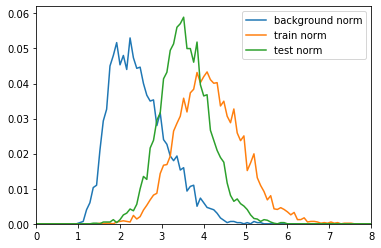

In [49]:
bacnorm_hist,tranorm_hist,valnorm_hist = feature(src='_result/EPSHN/CUB_R18/G8/0.0/')
plt.plot(np.linspace(0,8,101), bacnorm_hist.numpy(),label='background norm')
plt.plot(np.linspace(0,8,101), tranorm_hist.numpy(),label='train norm')
plt.plot(np.linspace(0,8,101), valnorm_hist.numpy(),label='test norm')
plt.legend()
plt.ylim(0,0.062)
plt.xlim(0,8)

Background dataset is not empty!



/opt/anaconda3/lib/python3.7/site-packages/torch/cuda/__init__.py:118: UserWarning: 
    Found GPU4 NVS 510 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


(0, 8)

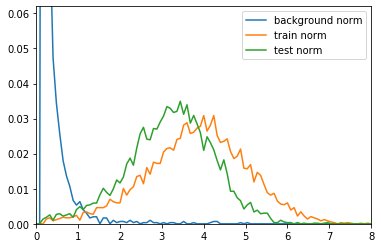

In [3]:
bacnorm_hist,tranorm_hist,valnorm_hist = feature(src='_result/EPSHN/CUB_R18/G8/0.1_bt64_w0.1_lr1e-2/')
plt.plot(np.linspace(0,8,101), bacnorm_hist.numpy(),label='background norm')
plt.plot(np.linspace(0,8,101), tranorm_hist.numpy(),label='train norm')
plt.plot(np.linspace(0,8,101), valnorm_hist.numpy(),label='test norm')
plt.legend()
plt.ylim(0,0.062)
plt.xlim(0,8)